# **Import**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

# GPU CONFIGURATION
from tensorflow.config.experimental import list_physical_devices, set_virtual_device_configuration, VirtualDeviceConfiguration, get_device_details
gpus = list_physical_devices('GPU')
print(len(gpus), "Physical GPUs:", get_device_details(gpus[0])['device_name'])
set_virtual_device_configuration(gpus[0], [VirtualDeviceConfiguration(memory_limit=1400)])

1 Physical GPUs: NVIDIA GeForce MX250


# **Data**

In [2]:
def sinus(x, A, w, t0):
    sinus = A * np.sin(x/w + t0)
    return sinus

def sinus_exp(x, A, w, t0, B, alfa, c0):
    sinus = A * np.sin(x/w + t0)
    exp = B * np.exp(alfa*x + c0)
    return sinus * exp

def sinus_cosinus(x, A, w, t0, B, w2, t02):
    sinus = A * np.sin(x/w + t0)
    cosinus = B * np.cos(x/w2 + t02)
    return sinus * cosinus

(3000,)


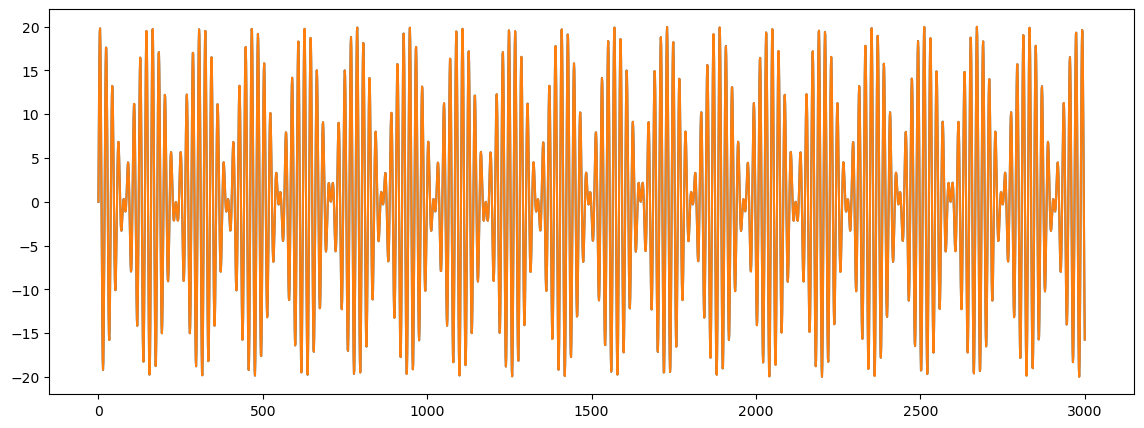

In [3]:
res = 1
tmax = 3000
N = int(tmax / res)
t = np.linspace(0, tmax, N)

# data = sinus_exp(t, A=20, w=3, t0=10, B=1, alfa=0.005, c0=0)
data = sinus_cosinus(t, A=20, w=3, t0=0, B=1, w2=50, t02=0)

noise = np.random.normal(0, 0.01, size=N)

plt.figure(figsize=(14,5))
plt.plot(t, data+noise)
plt.plot(t, data)

data = data+noise

print(data.shape)

# **Model**

In [4]:
model = Sequential()
# model.add(BatchNormalization())
model.add(LSTM(128, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mse')

# **Fitting**

Epoch 1/10
100/100 [==============================] - 16s 140ms/step - loss: 16.8709
Epoch 2/10
100/100 [==============================] - 13s 131ms/step - loss: 0.0401
Epoch 3/10
100/100 [==============================] - 13s 134ms/step - loss: 0.0151
Epoch 4/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0049
Epoch 5/10
100/100 [==============================] - 14s 137ms/step - loss: 0.0030
Epoch 6/10
100/100 [==============================] - 14s 144ms/step - loss: 0.0030
Epoch 7/10
100/100 [==============================] - 15s 149ms/step - loss: 0.0022
Epoch 8/10
100/100 [==============================] - 14s 141ms/step - loss: 0.0027
Epoch 9/10
100/100 [==============================] - 14s 142ms/step - loss: 0.0129
Epoch 10/10
100/100 [==============================] - 14s 142ms/step - loss: 0.0031


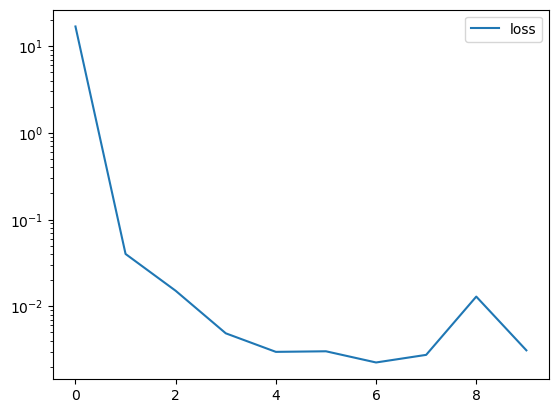

In [5]:
def data_generator(bs, Nmin, Nmax, N):
    while True:
        N2 = np.random.randint(Nmin, Nmax)
        t0s = np.random.randint(0, N-N2, size=bs)
        X = np.array([data[t0:t0+N2] for t0 in t0s]).reshape(-1, N2, 1)
        y = np.array([data[t0+N2] for t0 in t0s])
        yield X, y

history = model.fit(data_generator(128, 128, 1024, N),
                    # X_train, y_train,
                    # validation_data=(X_val, y_val),
                    # batch_size=10, 
                    steps_per_epoch=100, epochs=10, verbose=1)

plt.plot(history.history['loss'], label="loss")
# plt.plot(history.history['val_loss'], label="val_loss")
plt.yscale("log")
plt.legend(loc="upper right")
plt.show()

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 70,721
Trainable params: 70,721
Non-trainable params: 0
_________________________________________________________________


# **Extrapolate**

## **N2 = 256**

In [7]:
N2 = 256
Next = 256
X0 = data[-N2-Next:-Next]
y_pred0 = []
for i in range(Next):
    pred = model.predict(X0.reshape(1,N2,1))[0,0]
    y_pred0.append(pred)
    X0 = np.concatenate((X0[1:], [pred]))

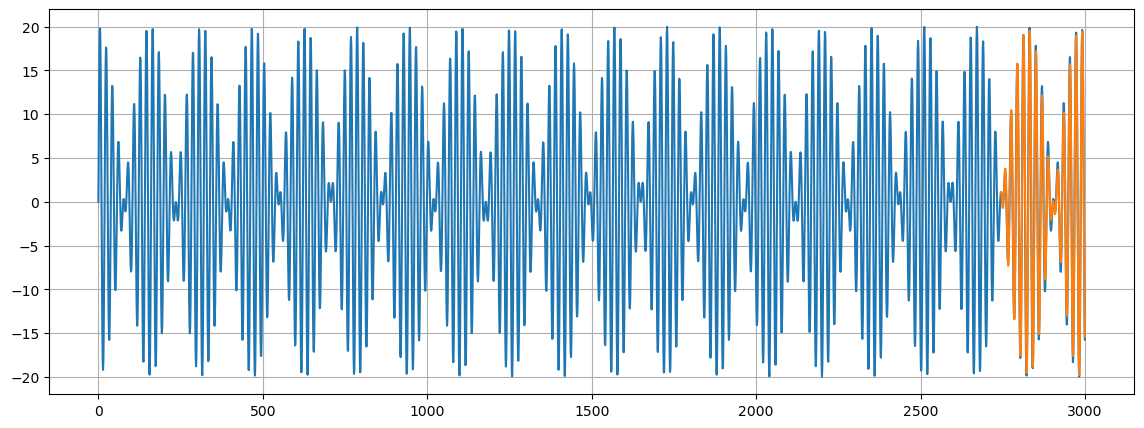

In [8]:
plt.figure(figsize=(14,5))
plt.plot(data, label="data")
# plt.plot(y_pred, label="prediction")
plt.plot(np.arange(N-Next,N), y_pred0, label="extrapolation")
plt.grid()
# plt.legend()

## **N2 = 128**

In [9]:
N2 = 128
Next = 256
X0 = data[-N2-Next:-Next]
y_pred0 = []
for i in range(Next):
    pred = model.predict(X0.reshape(1,N2,1))[0,0]
    y_pred0.append(pred)
    X0 = np.concatenate((X0[1:], [pred]))

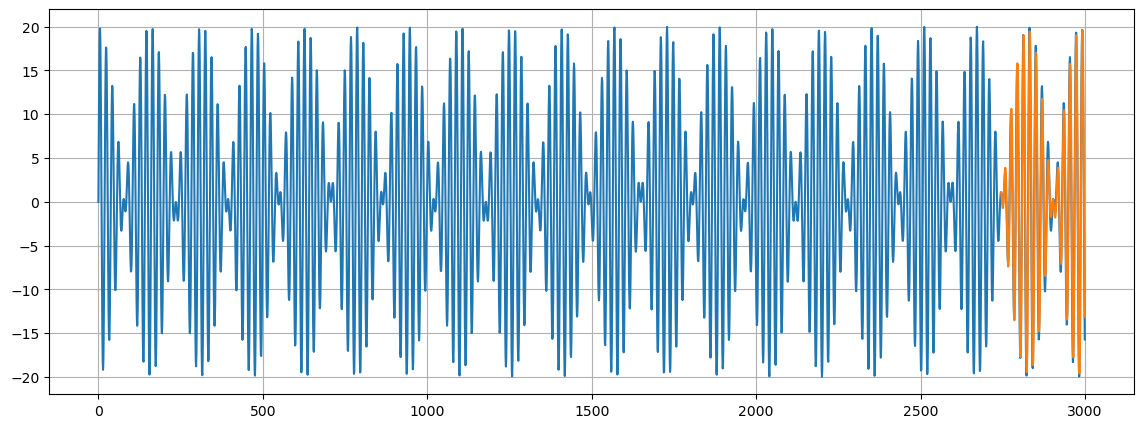

In [10]:
plt.figure(figsize=(14,5))
plt.plot(data, label="data")
# plt.plot(y_pred, label="prediction")
plt.plot(np.arange(N-Next,N), y_pred0, label="extrapolation")
plt.grid()
# plt.legend()